<a href="https://colab.research.google.com/github/kirubarajan/roft/blob/master/annotation/analysis/research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load from database

In [1]:
!pip install fsspec gcsfs

     |████████████████████████████████| 132 kB 4.2 MB/s 
     |████████████████████████████████| 1.1 MB 24.5 MB/s 
     |████████████████████████████████| 192 kB 45.9 MB/s 
     |████████████████████████████████| 160 kB 41.4 MB/s 
     |████████████████████████████████| 271 kB 42.1 MB/s 


In [2]:
import json
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set_theme(style="whitegrid")
sns.set_palette(sns.color_palette("Set2"))

DATABASE_DUMP_FILE = 'gs://roft_buckups/10-25-21.json'

In [3]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

In [4]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [5]:
with tf.io.gfile.GFile(DATABASE_DUMP_FILE, 'r') as f:
    lines = f.readlines()
    db = json.loads(lines[1])

def get_df(sql_model='core.annotation'):
    df = pd.DataFrame(db)
    df = df[df.model == sql_model]
    
    if 'date' in df.columns.values:
        df = df.set_index('date')

    return pd.json_normalize(df.fields).assign(pk=df.pk.values)

In [6]:
df = pd.DataFrame(db)
print(set(df["model"].tolist()))

{'contenttypes.contenttype', 'auth.permission', 'core.dataset', 'core.annotation', 'core.profile', 'core.timestamp', 'core.playlist', 'core.decodingstrategy', 'core.generation', 'core.feedbackoption', 'sessions.session', 'core.prompt', 'admin.logentry', 'auth.user', 'core.system'}


### Load all the tables

In [7]:
annotation_df = get_df()
profile_df = get_df('core.profile')
generation_df = get_df('core.generation')
prompt_df = get_df('core.prompt')
playlist_df = get_df('core.playlist')
decodingstrategy_df = get_df('core.decodingstrategy')
user_df = get_df('auth.user')

### Modify column names to avoid duplicates across tables.

In [8]:
prompt_df = prompt_df.rename(columns={"body": "prompt_body"})
generation_df = generation_df.rename(columns={"body": "gen_body"})
decodingstrategy_df = decodingstrategy_df.rename(
    columns={"name": "dec_strat", "value": "dec_strat_value"})
annotation_df["date"] = pd.to_datetime(annotation_df["date"])

### Merge all the relevant tables together.

In [9]:
gen_to_playlist = {}
for idx, row in playlist_df.iterrows():
  shortname = row["shortname"]
  version = row["version"]
  generations = row["generations"]
  for gen_id in generations:
    gen_to_playlist[gen_id] = (shortname, version)

In [10]:
full_df = annotation_df.join(generation_df.set_index('pk'), on='generation')
full_df = full_df.join(prompt_df.set_index('pk'), 'prompt')
full_df = full_df.join(decodingstrategy_df.set_index('pk'), 'decoding_strategy')
full_df = full_df.join(user_df.set_index('pk'), 'annotator')

In [11]:
playlist_names = [] 
playlist_versions = []
for idx, row in full_df.iterrows():
  gen_id = row["generation"]
  playlist_info = gen_to_playlist[gen_id]
  playlist_names.append(playlist_info[0])
  playlist_versions.append(playlist_info[1])
full_df["playlist_name"] = playlist_names
full_df["playlist_version"] = playlist_versions

### Filter out annotations not part of Version 2

In [12]:
full_df = full_df[full_df.apply(lambda row: row["playlist_version"]=="0.2", axis=1)]

## Filter out unacceptable users
Methods for filtering out annotations for users who have NOT agreed to have their data analyzed (and filtering out us).

**TO HAVE YOUR PROFILE FILTERED OUT, PLEASE FILL OUT THE GOOGLE FORM AND SPECIFY "NO" TO THE QUESTION ABOUT WHETHER YOU WANT TO PARTICIPATE IN RESEARCH.**

In [13]:
SURVEY_SPREADSHEET_ID = '1j9-nqsGFhpKSas_z1-IRKORlVbmjTzJ4_u_q6u-hOvg'
KEY = "ageed_to_research"
worksheet = gc.open_by_key(SURVEY_SPREADSHEET_ID).sheet1
rows = worksheet.get_all_values()

survey_df = pd.DataFrame.from_records(rows[1:], columns=rows[0])

survey_filter_df = survey_df[survey_df[KEY] == 'Yes']

# all the users who GAVE US PERMISSION
users_filter_df = user_df[user_df.username.isin(survey_filter_df["username"].values)]

# Filter all of the data frames that we use for analysis.
full_df = full_df[full_df.annotator.isin(users_filter_df.pk)]
annotation_df = annotation_df[annotation_df.annotator.isin(users_filter_df.pk)]

##Filter out user 4334
They are known to have used exploits and other scripts to manipulate the site

In [14]:
full_df = full_df[full_df['annotator'] != 4334]

##Add survey results to the DataFrame

In [15]:
full_df = full_df.join(survey_df.set_index('username'), 'username')

##Process survey responses
Map the familiarity questions to a 1-5 labeling scheme and process the "major" column to a list of major codes.

In [16]:
def remap_familiarity_labels(x):
  if x == "I've never heard of them.":
    return 1
  elif x == "I've read about them in the news or a blog post.":
    return 2
  elif x == "I’ve been excitedly following them.":
    return 3
  elif x == "I’ve used them before (either with the OpenAI API, HuggingFace Transformers, etc.).":
    return 4
  else:
    return -1

def remap_genre_fam_labels(x):
  if x == "Never":
    return 1
  elif x == "Once to a few times per year":
    return 2
  elif x == "Once to a few times per month":
    return 3
  elif x == "Once to a few times per week":
    return 4
  elif x == "Daily":
    return 5
  else:
    return -1

full_df = full_df.rename(columns={"What did you (or what are you planning to) major/minor in?": "major", 
                                              "How often do you consult a recipe when preparing food?": "recipe_familiarity", 
                                              'How often do you read news from credible news publishers (Philadelphia Inquirer, Wall Street Journal, New York Times, etc.)?':'news_familiarity', 
                                              'How often do you read fiction on the internet (fan fiction, creative writing sub-reddits, ebooks, etc.)?':'stories_familiarity',
                                              'familiarity':'gen_familiarity',
                                              'Did you read the RoFT Guide before you tried the game?': 'read_guide'})

full_df['recipe_familiarity'] = full_df['recipe_familiarity'].apply(remap_genre_fam_labels)
full_df['news_familiarity'] = full_df['news_familiarity'].apply(remap_genre_fam_labels)
full_df['stories_familiarity'] = full_df['stories_familiarity'].apply(remap_genre_fam_labels)
full_df['gen_familiarity'] = full_df['gen_familiarity'].apply(remap_familiarity_labels)

## Process Majors
Parse the free text responses into one of 34 different major codes

In [17]:
def process_major(x):
  major_labels = []
  CIS = ['Computer and Information Science', 'CIS', 'Computer Science', 'Computer science', 'CS', 'Comp sci', 'computer science', 'cis', 'CSCI']
  MCIT = ['MICT', 'MCIT', 'Computer and Information Technology', 'Information Technology', 'Computer & Information Technology', 'Computer and information tech', 'mcit', 'OMCIT', 'Computer and Information Tech', 'Computer Information and Technology', 'Computer Information Technology', 'Computer and Info Tech', 'CIT', 'computer information technology', 'Computer Science and information Technology', 'cit']
  FIN = ['Finance', 'finance', 'Business Analytics']
  ACCT = ['accounting', 'Accounting']
  BA = ['Business Administration']
  QM = ['quantitative methods']
  CMPE = ['Computer Engineering']
  PHYS = ['Physics', 'physics']
  COM = ['Communications', 'communications']
  COG = ['cognitive science', 'Cognitive Science']
  CBIO = ['Computational Biology']
  ROBO = ['ROBO', 'Robotics']
  LING = ['Linguistics', 'LING']
  EE = ['Environmental Engineering']
  ESE = ['ESE', 'electrical engineering', 'EE']
  NETS = ['NETS', 'Networked and Social Systems Engineering', 'Systems Engineering']
  DATS = ['Data Science', 'data science', 'DATS']
  BIO = ['Biology', 'biology']
  ARTH = ['Art History']
  HIST = ['History', 'history', 'HIST']
  PHIL = ['Philosophy']
  ENT = ['Entrepreneurship']
  DMD = ['DMD', 'Digital Media Design']
  MATH = ['MATH', 'math', 'mathematics', 'Mathematics']
  MED = ['medicine']
  NEURO = ['neuroscience', 'Neuroscience']
  BE = ['BE', 'bioengineering', 'Bioengineering']
  CBE = ['Chemical Engineering']
  CIV = ['civil engineering', 'Civil Engineer']
  MEAM = ['MEAM', 'mechanical engineering', 'Mechanical Engineering']
  ECON = ['Economics', 'ECON']
  CGGT = ['CGGT', 'Computer Graphics and Game Technology']
  SCMP = ['Scientific Computing']

  if any(substring in x for substring in CIS):
    major_labels.append("CIS")
  if any(substring in x for substring in MCIT):
    major_labels.append("MCIT")
  if any(substring in x for substring in FIN):
    major_labels.append("FIN")
  if any(substring in x for substring in ACCT):
    major_labels.append("ACCT")
  if any(substring in x for substring in BA):
    major_labels.append("BA")
  if any(substring in x for substring in QM):
    major_labels.append("QM")
  if any(substring in x for substring in PHYS):
    major_labels.append("PHYS")
  if any(substring in x for substring in COM):
    major_labels.append("COM")
  if any(substring in x for substring in COG):
    major_labels.append("COG")
  if any(substring in x for substring in CBIO):
    major_labels.append("CBIO")
  if any(substring in x for substring in ROBO):
    major_labels.append("ROBO")
  if any(substring in x for substring in LING):
    major_labels.append("LING")
  if any(substring in x for substring in EE):
    major_labels.append("EE")
  if any(substring in x for substring in ESE):
    major_labels.append("ESE")
  if any(substring in x for substring in NETS):
    major_labels.append("NETS")
  if any(substring in x for substring in DATS):
    major_labels.append("DATS")
  if any(substring in x for substring in BIO):
    major_labels.append("BIO")
  if any(substring in x for substring in ARTH):
    major_labels.append("ARTH")
  if any(substring in x for substring in HIST):
    major_labels.append("HIST")
  if any(substring in x for substring in PHIL):
    major_labels.append("PHIL")
  if any(substring in x for substring in ENT):
    major_labels.append("ENT")
  if any(substring in x for substring in DMD):
    major_labels.append("DMD")
  if any(substring in x for substring in MATH):
    major_labels.append("MATH")
  if any(substring in x for substring in MED):
    major_labels.append("MED")
  if any(substring in x for substring in NEURO):
    major_labels.append("NEURO")
  if any(substring in x for substring in BE):
    major_labels.append("BE")
  if any(substring in x for substring in CIV):
    major_labels.append("CIV")
  if any(substring in x for substring in MEAM):
    major_labels.append("MEAM")
  if any(substring in x for substring in ECON):
    major_labels.append("ECON")
  if any(substring in x for substring in CGGT):
    major_labels.append("CGGT")
  if any(substring in x for substring in CMPE):
    major_labels.append("CMPE")
  if any(substring in x for substring in CBE):
    major_labels.append("CBE")
  if any(substring in x for substring in SCMP):
    major_labels.append("SCMP")

  if x == 'Engineering':
    major_labels.append("ENG")
  if x == 'Computer':
    major_labels.append("MCIT")
  if x == 'AI':
    major_labels.append("AI")
  if x == 'urban planning':
    major_labels.append('URB')
  if x == 'Stories':
    major_labels.append('STOR')

  return major_labels

full_df['major'] = full_df['major'].apply(process_major)

## Cleaning up 
Rename columns and delete unused columns

In [18]:
## TODO: Figure out what the "decoding_strategy" and "dataset" fields actually do -- do they indicate the source generations file? If so, might be able to use to recover CTRL splits

columns_to_drop = ['attention_check', 'dec_strat', 'password', 'last_login', 'is_superuser', 'is_staff', 'first_name', 'last_name', 'email', 'is_active', 'groups', 'user_permissions', 'playlist_version', 'ageed_to_research', 'dataset', 'decoding_strategy']
full_df = full_df.drop(columns_to_drop, axis=1)

full_df = full_df.rename(columns={'system':'model','playlist_name':'dataset', 'boundary':'predicted_boundary_index', 'num_sentences':'true_boundary_index'})
full_df['true_boundary_index'] = full_df['true_boundary_index'] - 1

##Reorder Columns
Re-order columns so that they make sense and are easier to read

In [19]:
column_order = ['date', 'username', 'dataset', 'model', 'dec_strat_value', 'prompt', 'prompt_body', 'generation', 'gen_body','true_boundary_index', 'predicted_boundary_index', 'points', 'major', 'english', 'read_guide', 'recipe_familiarity', 'news_familiarity', 'stories_familiarity', 'gen_familiarity', 'prompt_index', 'annotator', 'date_joined', 'Timestamp', 'Email Address']
full_df[column_order]

,date,username,dataset,model,dec_strat_value,prompt,prompt_body,generation,gen_body,true_boundary_index,predicted_boundary_index,points,major,english,read_guide,recipe_familiarity,news_familiarity,stories_familiarity,gen_familiarity,prompt_index,annotator,date_joined,Timestamp,Email Address
112,2021-08-31 17:11:39.095000+00:00,mcolombo,Recipes,finetuned,0.4,13803,HOW TO MAKE: Baby Shell Pasta Salad With Kalam...,22877,"Meanwhile, combine all dressing ingredients in...",2,0,0,[NETS],Yes,,2,3,5,2,2130,1666,2021-08-31T17:10:18.716Z,9/6/2021 18:14:26,mcolombo@seas.upenn.edu
114,2021-08-31 17:12:40.795000+00:00,mcolombo,Recipes,gpt2-xl,0.4,16433,HOW TO MAKE: Open Faced Italian Dogs\nIngredie...,21386,,9,9,5,[NETS],Yes,,2,3,5,2,9933,1666,2021-08-31T17:10:18.716Z,9/6/2021 18:14:26,mcolombo@seas.upenn.edu
138,2021-09-02 02:27:39.754000+00:00,Hongyu Zhang,Recipes,finetuned,0.4,20538,HOW TO MAKE: Black Sesame Seed Bagels\nIngredi...,26262,Brush with malt syrup or sugar._SEP_Bake for 1...,7,3,0,[CIS],No,,4,4,4,2,7824,1699,2021-09-02T02:26:11.170Z,9/6/2021 13:53:15,hz53@seas.upenn.edu
172,2021-09-02 13:41:57.862000+00:00,Xuanyang,Short Stories,gpt2,0.4,1810,Don't worry about credit- if anything always j...,1785,It was probably because they were really old e...,7,1,0,[ROBO],No,,2,2,4,4,2739,1720,2021-09-02T13:36:57.794Z,9/3/2021 21:55:38,wxy@seas.upenn.edu
179,2021-09-02 13:44:42.769000+00:00,zszeke,Recipes,finetuned,0.4,20654,HOW TO MAKE: Simply Elegant Green Beans\nIngre...,26379,Just increase the amount of walnuts to 2/3 cup...,8,1,0,[ESE],Yes,,4,1,4,1,8030,1727,2021-09-02T13:42:23.614Z,9/4/2021 16:38:17,zszeke@seas.upenn.edu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46968,2021-10-18 04:36:47.625000+00:00,sweetMelon,Recipes,finetuned,0.4,20608,HOW TO MAKE: Baked Salmon Fillets Dijon\nIngre...,26332,The one serving is 12 ounces per person!_SEP_G...,7,9,3,[MCIT],No,Yes,2,4,4,3,7943,4433,2021-10-07T12:25:48.534Z,10/16/2021 4:37:46,jiayuzhu@seas.upenn.edu
46969,2021-10-18 04:37:01.490000+00:00,sweetMelon,Recipes,finetuned,0.4,13785,HOW TO MAKE: Delicious Greek Garlic Chicken\nI...,22806,Pour the boiling water over the chicken pieces...,2,7,0,[MCIT],No,Yes,2,4,4,3,2017,4433,2021-10-07T12:25:48.534Z,10/16/2021 4:37:46,jiayuzhu@seas.upenn.edu
46970,2021-10-18 04:37:12.887000+00:00,sweetMelon,Recipes,finetuned,0.4,19077,HOW TO MAKE: Cheddar-Polenta Biscuits with Ham...,24651,Transfer the biscuits to the prepared baking s...,4,9,0,[MCIT],No,Yes,2,4,4,3,4999,4433,2021-10-07T12:25:48.534Z,10/16/2021 4:37:46,jiayuzhu@seas.upenn.edu
46971,2021-10-18 04:37:24.752000+00:00,sweetMelon,Recipes,gpt2-xl,0.4,15183,HOW TO MAKE: Asparagus Omelette\nIngredients:\...,20136,Melt the remaining 4 tablespoons butter in a l...,1,9,0,[MCIT],No,Yes,2,4,4,3,1396,4433,2021-10-07T12:25:48.534Z,10/16/2021 4:37:46,jiayuzhu@seas.upenn.edu


# Helper Functions

In [20]:
def map_playlist_name(playlist):
  """Converts playlist names to the ones we want to use in the paper."""
  if playlist == 'New York Times':
    return "News"
  elif playlist == 'Presidential Speeches':
    return "Speeches"
  elif playlist == 'Recipes':
    return "Recipes"
  elif playlist == 'Short Stories':
    return "Stories"

def save(filename):
  plt.tight_layout()
  plt.savefig(filename)
  plt.show()

# Dataset Statistics

In [21]:
full_df.groupby('dataset').count()

,date,annotator,generation,playlist,predicted_boundary_index,points,reason,pk,model,prompt,gen_body,prompt_body,true_boundary_index,prompt_index,dec_strat_value,username,date_joined,Timestamp,Email Address,major,english,recipe_familiarity,news_familiarity,stories_familiarity,gen_familiarity,read_guide
dataset,,,,,,,,,,,,,,,,,,,,,,,,,,
New York Times,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999
Presidential Speeches,5180,5180,5180,5180,5180,5180,5180,5180,5180,5180,5180,5180,5180,5180,5180,5180,5180,5180,5180,5180,5180,5180,5180,5180,5180,5180
Recipes,12152,12152,12152,12152,12152,12152,12152,12152,12152,12152,12152,12152,12152,12152,12152,12152,12152,12152,12152,12152,12152,12152,12152,12152,12152,12152
Short Stories,5208,5208,5208,5208,5208,5208,5208,5208,5208,5208,5208,5208,5208,5208,5208,5208,5208,5208,5208,5208,5208,5208,5208,5208,5208,5208


# Analysis

## Mean points

In [22]:
def analyze_per_playlist():
  info_to_return = []
  playlist_names = set(playlist_df["shortname"].tolist())
  model_names = set(generation_df["system"].tolist())
  for playlist in playlist_names:
    for model in model_names:
      df = full_df[(full_df["dataset"]==playlist) & 
                          (full_df["model"]==model)]
      
      if len(df) > 0:
        info = {"playlist": playlist,
                "model": model,
                "mean score": np.mean(df["points"]),
                "median score": np.median(df["points"]),
                "fraction_nonzero": len(df[df["points"] > 0]) / len(df),
                "num_annotations": len(df)
        }
        info_to_return.append(info)
  return pd.DataFrame(info_to_return)

analyze_per_playlist()

,playlist,model,mean score,median score,fraction_nonzero,num_annotations
0,New York Times,gpt2-xl,1.841037,1.0,0.522067,4781
1,New York Times,easy,2.779817,3.0,0.715596,218
2,Short Stories,gpt2-xl,1.930540,1.0,0.555683,1742
3,Short Stories,davinci,1.858974,1.0,0.628205,78
4,Short Stories,gpt2,2.171192,2.0,0.537190,3388
5,Recipes,finetuned,1.974107,1.0,0.525756,7338
6,Recipes,gpt2-xl,2.169921,0.0,0.497923,4814
7,Presidential Speeches,ctrl,2.117954,2.0,0.572008,5180


In [23]:
def analyze_per_decoding_strat():
  info_to_return = []
  playlist_names = set(playlist_df["shortname"].tolist())
  model_names = set(generation_df["system"].tolist())
  for playlist in playlist_names:
    for model in model_names:
      for top_p_value in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        df = full_df[(full_df["dec_strat_value"]==top_p_value) &
                  (full_df["dataset"]==playlist) &
                  (full_df["model"]==model)]

        if len(df) > 0:
          info = {"p-value": top_p_value,
                  "playlist": playlist,
                  "model": model,
                  "mean_score": np.mean(df["points"]),
                  "std_dev": np.std(df["points"]),
                  "median_score": np.median(df["points"]),
                  "fraction_nonzero": len(df[df["points"] > 0]) / len(df),
                  "num_annotations": len(df),
          }
          info_to_return.append(info)
  return pd.DataFrame(info_to_return)

per_p_df = analyze_per_decoding_strat()
per_p_df

,p-value,playlist,model,mean_score,std_dev,median_score,fraction_nonzero,num_annotations
0,0.0,New York Times,gpt2-xl,1.672914,1.953827,0.0,0.492745,1654
1,0.4,New York Times,gpt2-xl,1.754754,1.975967,1.0,0.506230,1525
2,1.0,New York Times,gpt2-xl,2.096754,2.088552,2.0,0.567416,1602
3,0.0,Short Stories,gpt2-xl,1.550088,1.879883,0.0,0.483304,569
4,0.4,Short Stories,gpt2-xl,1.873377,2.014607,1.0,0.542208,616
5,1.0,Short Stories,gpt2-xl,2.382406,2.040676,3.0,0.644524,557
6,0.4,Short Stories,davinci,1.858974,1.872366,1.0,0.628205,78
7,0.4,Short Stories,gpt2,2.171192,2.181866,2.0,0.537190,3388
8,0.4,Recipes,finetuned,1.974107,2.128826,1.0,0.525756,7338
9,0.4,Recipes,gpt2-xl,2.169921,2.345651,0.0,0.497923,4814


### Comparison of XL models across p-values for NYT and Reddit

**Conclusion**: Sampling from full distribution (p=1.0) has worse quality. Argmax sampling (with repetition penalty) seems to be consistently better for text quality -- this is consistent with Daphne's research.

Text(0, 0.5, 'Mean Score')

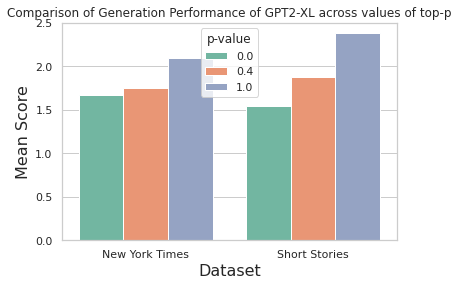

In [24]:
filtered_df = per_p_df[(per_p_df["model"]=="gpt2-xl") & 
                                     (per_p_df["playlist"]=="Short Stories") | 
                                     (per_p_df["playlist"]=="New York Times")]

p = sns.barplot(x="playlist", y="mean_score", hue="p-value", data=filtered_df)
p.set_title("Comparison of Generation Performance of GPT2-XL across values of top-p")
p.set_xlabel("Dataset", fontsize = 16)
p.set_ylabel("Mean Score", fontsize = 16)

### Comparison of GPT2-XL p=0.4 across reddit, nyt, and recipes

**Conclusion:** We see that Recipes are the most difficult, then NYT and short stories. This shows that generation systems struggle with structured text and are better at more open-ended generations (?). Also shows that domain knowledge is important. (although NYT being better than reddit is interesting).

Text(0, 0.5, 'Mean Score')

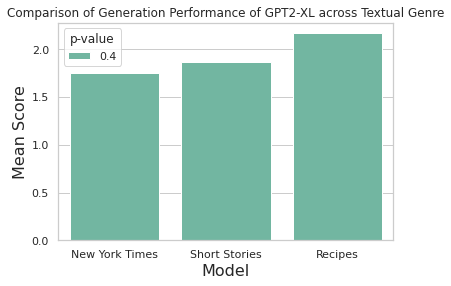

In [25]:
filtered_df = per_p_df[(per_p_df["model"]=="gpt2-xl") & 
                                     (per_p_df["p-value"]==0.4)]

p = sns.barplot(x="playlist", y="mean_score", hue="p-value", data=filtered_df)
p.set_title("Comparison of Generation Performance of GPT2-XL across Textual Genre")
p.set_xlabel("Model", fontsize = 16)
p.set_ylabel("Mean Score", fontsize = 16)

### Comparison of Model Size across same dataset and p-value

**Conclusion**: Bigger Models are better (good sanity check, nice to know this is confirmed) -- don't use GPT3 here because we only have 89 annotations

Text(0, 0.5, 'Mean Score')

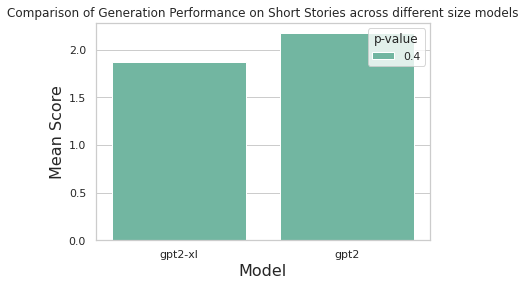

In [26]:
filtered_df = per_p_df[(per_p_df["playlist"]=="Short Stories") & 
                                     (per_p_df["p-value"]==0.4) & 
                                     (per_p_df["model"]!="davinci")]

p = sns.barplot(x="model", y="mean_score", hue="p-value", data=filtered_df)
p.set_title("Comparison of Generation Performance on Short Stories across different size models")
p.set_xlabel("Model", fontsize = 16)
p.set_ylabel("Mean Score", fontsize = 16)

### Comparison of fine-tuning performance

Text(0, 0.5, 'Mean Score')

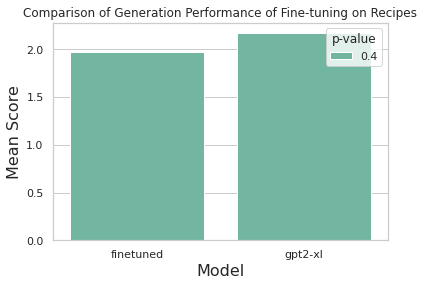

In [27]:
filtered_df = per_p_df[(per_p_df["playlist"]=="Recipes")]

p = sns.barplot(x="model", y="mean_score", hue="p-value", data=filtered_df)
p.set_title("Comparison of Generation Performance of Fine-tuning on Recipes")
p.set_xlabel("Model", fontsize = 16)
p.set_ylabel("Mean Score", fontsize = 16)

###Mean Points for users that have no familiarity with generated text vs. users that do

(-0.6, 5.5)

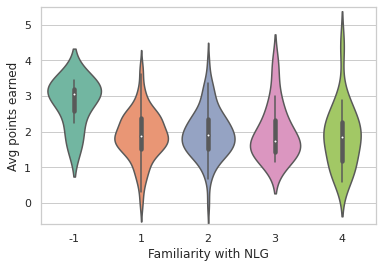

In [28]:
df_familiarity=full_df.groupby(["username", "gen_familiarity"]).points.mean().reset_index()
df_familiarity.rename({"gen_familiarity": "Familiarity with NLG", "points": "Avg points earned"}, axis=1, inplace=True)
sns.violinplot(x="Familiarity with NLG", y="Avg points earned", data=df_familiarity)
plt.ylim([-0.6, 5.5])

### Mean Points for native vs. non-native English speakers

(-0.6, 5.5)

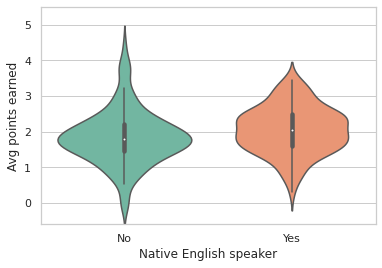

In [29]:
df_language=full_df.groupby(["username", "english"]).points.mean().reset_index()
df_language.rename({"english": "Native English speaker", "points": "Avg points earned"}, axis=1, inplace=True)
sns.violinplot(x="Native English speaker", y="Avg points earned", data=df_language)
plt.ylim([-0.6, 5.5])

##Mean points for users with familiarity in a given domain
TODO

## Point Distributions

### Per playlist

In [30]:
import collections

In [31]:
df = full_df[full_df["model"].isin(('ctrl', 'finetuned', 'gpt2-xl'))]
df = df[df["dec_strat_value"] == 0.4]

playlists = set(df["dataset"].tolist())
to_plot = []
for playlist in playlists:
  points = df[df["dataset"]==playlist].points.tolist()
  points = collections.Counter(points)

  heights = np.array(list(points.values())) / sum(points.values())
  for point_value, height in zip(points, heights):
    to_plot.append({"Points earned": point_value,
                    "Fraction of annotations":height,
                    "Domain": map_playlist_name(playlist)})

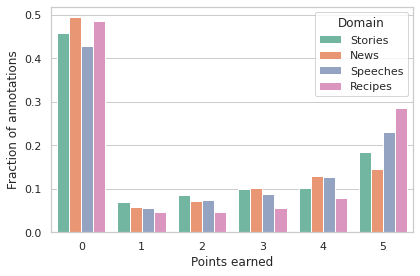

In [32]:
to_plot = pd.DataFrame(to_plot)
sns.barplot(x="Points earned", y="Fraction of annotations", hue="Domain", data=to_plot)
save("point_distribution.pdf")

### Per annotator

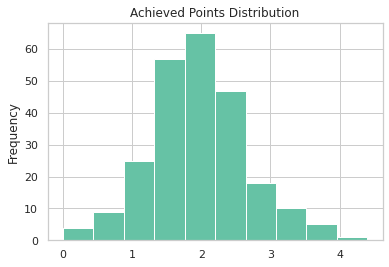

In [33]:
full_df.groupby('annotator').points.mean().plot.hist(
    title='Achieved Points Distribution'
)

## Annotator performance over time

Of the annotators who did at least K annotations, plot their mean score over time

In [34]:
def analyze_progress(df, k=50):
  """Analyze whether annotators improve in aggregate over k annotations."""
  all_score_series = []
  annotators = df[df["pk"] > k].reset_index()["annotator"].tolist()
  for annotator in annotators:
    annotations = annotation_df[annotation_df["annotator"] == annotator]
    score_series = annotations.sort_values("date")["points"][:k].tolist()
    all_score_series.append(score_series)

  return np.array(all_score_series), len(annotators)

In [35]:
def analyze_and_plot(s, n, k):
  print(n)
  data = np.array(s)
  data = np.mean(data, axis=0)
  print("spearmanr: %.2f, %f" % stats.spearmanr(range(k), data))
  print("pearsonr: %.2f, %f" % stats.pearsonr(range(k), data))
  plt.plot(range(1, k+1), data)
  plt.ylabel("Mean score")
  plt.xlabel("$n$th annotation")
  plt.title("Performance over time")
  plt.show()

### Analysis of annotators getting better over time (1st Batch)

**Conclusion**: We see no correlation on the first batch of annotators. They do not improve over time

23
spearmanr: -0.16, 0.276470
pearsonr: -0.11, 0.462299


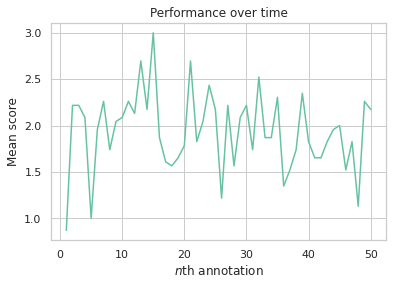

In [36]:
k = 50
s, n = analyze_progress(full_df[(full_df['date'] < '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k)

13
spearmanr: -0.04, 0.685869
pearsonr: -0.02, 0.862583


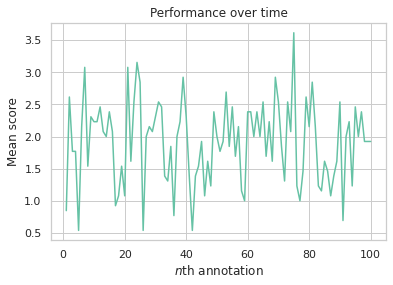

In [37]:
k = 100
s, n = analyze_progress(full_df[(full_df['date'] < '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k)

4
spearmanr: -0.03, 0.710323
pearsonr: 0.00, 0.950708


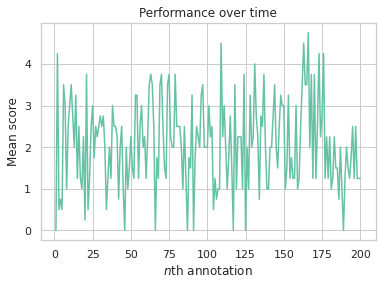

In [38]:
k = 200
s, n = analyze_progress(full_df[(full_df['date'] < '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k)

### Analysis of annotators getting better over time (2nd Batch)

**Conclusion**: We actually see a positive correlation (over 0.3) for k=50, 100, and 200 on the second batch of annotators. They DO actually improve over time. This suggests that, with the correct instructions, annotators may be able to be taught how to improve at detecting generated text.

92
spearmanr: 0.40, 0.004396
pearsonr: 0.36, 0.011222


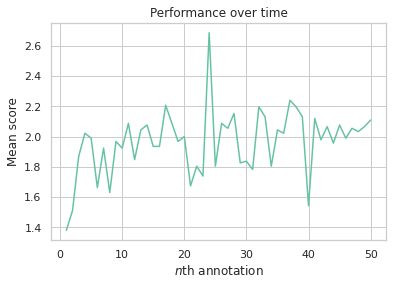

In [39]:
k = 50
s, n = analyze_progress(full_df[(full_df['date'] > '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k)

87
spearmanr: 0.59, 0.000000
pearsonr: 0.59, 0.000000


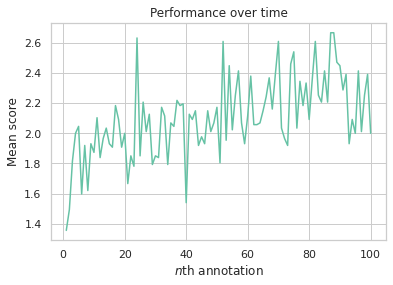

In [40]:
k = 100
s, n = analyze_progress(full_df[(full_df['date'] > '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k)

55
spearmanr: 0.35, 0.000000
pearsonr: 0.34, 0.000001


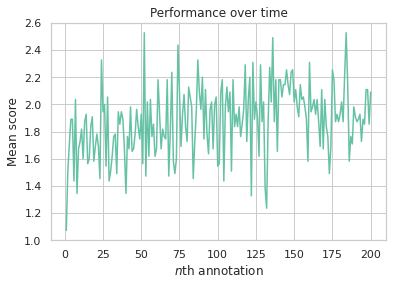

In [41]:
k = 200
s, n = analyze_progress(full_df[(full_df['date'] > '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k)

## Inter-annotator agreement

### Difference in abilities

In [42]:
def analyze_ability_differences(df, k=50):
  """Analyze whether annotators improve in aggregate over k annotations."""
  df = df.groupby('annotator').count()
  all_score_series = []
  annotators = df[df["pk"] >= k].reset_index()["annotator"].tolist()
  for annotator in annotators:
    annotations = annotation_df[annotation_df["annotator"] == annotator]
    score_series = annotations.sort_values("date")["points"][:k].tolist()
    all_score_series.append(score_series)
    
  return all_score_series

In [43]:
scores = analyze_ability_differences(full_df, 50)
sum_scores = [sum(s) for s in scores]

In [44]:
print("Mean score:", np.mean(sum_scores))
print("Std score:", np.std(sum_scores))

Mean score: 97.8103448275862
Std score: 27.55274371252327


In [45]:
df = full_df.groupby('annotator').count()
annotators = df[df["pk"] >= 50].reset_index()["annotator"].tolist()

df = full_df[full_df["annotator"].isin(annotators)]
df = df.groupby('annotator').sum()
# df = annotation_df.groupby('generation').boundary.apply(list).reset_index()
# df = df[df.apply(lambda row: len(row["boundary"]) >= 4, axis=1)]

### Fraction agreement
For every pair of annotators who annotated the same generaton, what fraction guessed the same boundary?

In [46]:
annotations_per_gen = annotation_df.groupby('generation')
num_annotations_per_gen = annotations_per_gen.points.count()

In [69]:
def analyze_fraction_agreements():
  generation_ids = set(full_df["generation"].tolist())
  annotations_per_gen = full_df.groupby('generation')

  overall_num_annotations = 0
  overall_num_agreements = 0

  x = annotations_per_gen.predicted_boundary_index.value_counts()
  for idx, generation in enumerate(generation_ids):
    chosen_boundaries = x[generation]
    chosen_boundaries = {k: chosen_boundaries[k] for k in chosen_boundaries.keys()}
    
    total_annotations = sum(chosen_boundaries.values())
    if total_annotations > 1:
      total_agreements = sum(v for v in chosen_boundaries.values() if v > 1)

      overall_num_annotations += total_annotations
      overall_num_agreements += total_agreements

  print("Out of {} total annotations on generations with >1 annotation, {} were in agreement with another annotation on the true boundary position. That is {}".format(
      overall_num_annotations, overall_num_agreements, overall_num_agreements/overall_num_annotations
  ))
analyze_fraction_agreements()

# TODO: Figure out what the baseline of random guessing would be,

Out of 26962 total annotations on generations with >1 annotation, 13098 were in agreement with another annotation on the true boundary position. That is 0.48579482234255617


### Krippendorf's Alpha

In [49]:
import nltk.metrics

In [50]:
from nltk.metrics.agreement import AnnotationTask

In [51]:
df = full_df.groupby('generation').predicted_boundary_index.apply(list).reset_index()
df = df[df.apply(lambda row: len(row["predicted_boundary_index"]) >= 4, axis=1)]

In [52]:
annotation_data = []
for idx, row in full_df.iterrows():
  coder = row["annotator"]
  item = row["generation"]
  label = row["predicted_boundary_index"]
  annotation_data.append((coder,item,label))

In [53]:
ann_task = AnnotationTask(annotation_data)

In [54]:
print(ann_task.alpha())

-0.3898732837295591


## Profile Statistics

In [55]:
def user_stats(df, name):
  data = {"name": name}
  data["num_participants"] = len(np.unique(df["annotator"]).tolist())
  data["num_annotations"] = len(df)
  data["mean_annotations_per_participant"] = data["num_annotations"] / data["num_participants"] 
  data["mean_points"] = np.mean(df["points"])
  data["std_points"] = np.std(df["points"])
  return data

In [56]:
all_data = []
all_data.append(user_stats(full_df, "overall"))
all_data.append(user_stats(full_df[(full_df['date'] <= '2021-10-1')], "Section A"))
all_data.append(user_stats(full_df[(full_df['date'] > '2021-10-1')], "Section B"))

In [57]:
pd.DataFrame(all_data)

,name,num_participants,num_annotations,mean_annotations_per_participant,mean_points,std_points
0,overall,241,27539,114.26971,2.039834,2.147400
1,Section A,141,7264,51.51773,1.947274,2.147596
2,Section B,102,20275,198.77451,2.072996,2.146358


# Time Tracking Analysis
TODO: double check that timestamps are properly merged with the correct annotations. Also find a better way to calculate time delta than shift down by 1 and filter.

In [58]:
timing_df = get_df('core.timestamp')
timing_df = timing_df.rename(columns={'date': 'timestamp'}).merge(full_df, left_on='annotation', right_on='pk')

In [59]:
timing_df['timestamp'] = pd.to_datetime(timing_df.timestamp)
timing_df['delta'] = timing_df.timestamp - timing_df.timestamp.shift(1)
timing_df['delta'] = timing_df.delta.dt.components.milliseconds / 1000.0 + timing_df.delta.dt.components.seconds + timing_df.delta.dt.components.minutes * 60.0
timing_df = timing_df[timing_df.delta < 120] # TODO: Do this more properly instead of shift and filter

## Median Time Delta

In [60]:
timing_df.delta.median()

2.16

## Correlation Between Time Delta and Decoding Hyperparameter (top-p)

In [61]:
timing_df[['dec_strat_value', 'delta']].corr()

,dec_strat_value,delta
dec_strat_value,1.00000,-0.00294
delta,-0.00294,1.00000


## Time Delta Distribution

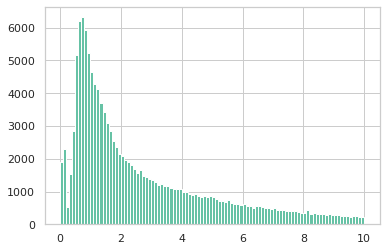

In [62]:
timing_df.delta.hist(bins=100, range=(0,10))
#plot( kind='hist',    range=(0, 60),    bins=30,    figsize=(20, 10),    title=('Turn Duration Distribution (seconds)')  )

## Correlation Between Time Delta and Sentence Length

In [63]:
timing_df['gen_body_length'] = timing_df.gen_body.str.len()
timing_df.groupby('annotation').agg({'delta': 'sum', 'gen_body_length': 'mean'}).corr()

,delta,gen_body_length
delta,1.000000,-0.080672
gen_body_length,-0.080672,1.000000


## Correlation Between Time Delta and Points

In [64]:
timing_df.groupby('annotation').agg({'delta': 'sum', 'points': 'mean'}).corr()

,delta,points
delta,1.000000,0.140203
points,0.140203,1.000000


## Comparison of Average Time Deltas Between Text Domains

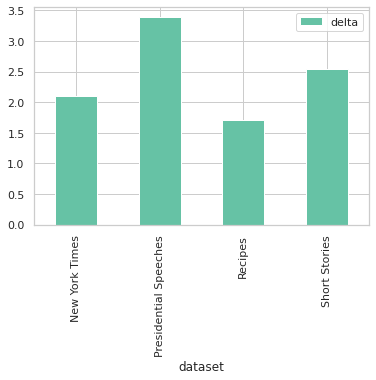

In [65]:
# Median
timing_df.groupby('dataset').agg({'delta': 'median'}).plot.bar()

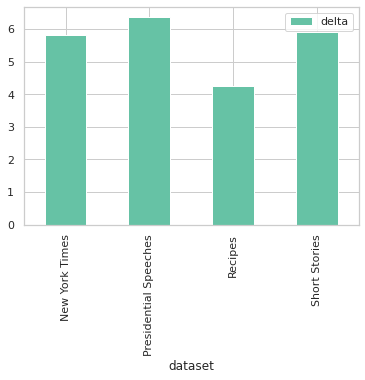

In [66]:
# Mean
timing_df.groupby('dataset').agg({'delta': 'mean'}).plot.bar()

## Comparison of Average Time Deltas Between Models

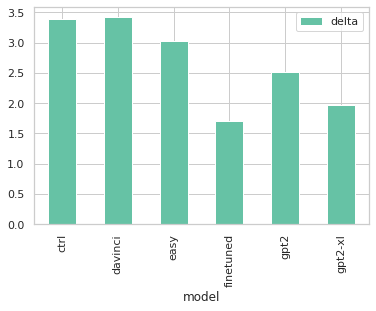

In [67]:
# Median
timing_df.groupby('model').agg({'delta': 'median'}).plot.bar()

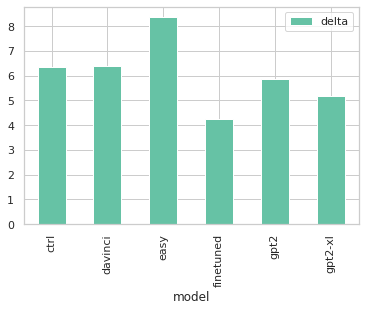

In [68]:
# Mean
timing_df.groupby('model').agg({'delta': 'mean'}).plot.bar()